# Project predicts the closing price of stocks using SVR ,LSTM, GRU, ARIMA with sentimental analysis.

Steps Involved the project:

1) Choosing the dataset with appropriate features. Here we are taking the Yahoo finance dataset for year 2017-2022.

This Dataset comprises of various features like:
Date, Open, High, Low, Close, Adj Close, Volume.


In [ ]:
#importing libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import datetime as dt

import plotly.graph_objects as go
import plotly.express as px

from itertools import cycle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import metrics
%matplotlib inline


Next Installing Yfinance for the dataset

In [ ]:
!pip install yfinance

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Loading the training dataset form the year 2017-2022.
( Specifically for 2017-03-31 to 2022-03-31).

We will use the yfinance library for loading the dataset.

In [ ]:
import yfinance as yf
# Dataset for Training
bsedata = yf.download('^BSESN', start='2017-03-31', end='2021-03-31')

[*********************100%%**********************]  1 of 1 completed


## Explodatory data analyis.

In [ ]:
bsedata.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-03-31,29633.910156,29687.640625,29552.609375,29620.500000,29620.500000,11800
2017-04-03,29737.730469,29926.939453,29705.720703,29910.220703,29910.220703,10100
2017-04-05,29996.029297,30007.480469,29817.689453,29974.240234,29974.240234,11200
2017-04-06,29946.890625,29954.250000,29817.589844,29927.339844,29927.339844,11300
2017-04-07,29850.710938,29886.119141,29668.449219,29706.609375,29706.609375,14700


In [ ]:
bsedata.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-23,49876.210938,50264.648438,49661.921875,50051.441406,50051.441406,13400
2021-03-24,49786.468750,49854.578125,49120.339844,49180.308594,49180.308594,9200
2021-03-25,49201.980469,49247.949219,48236.351562,48440.121094,48440.121094,14300
2021-03-26,48969.250000,49234.660156,48699.910156,49008.500000,49008.500000,10600
2021-03-30,49331.679688,50268.449219,49331.679688,50136.578125,50136.578125,10500


In [ ]:
train = bsedata.reset_index() # set index to column

In [ ]:
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-03-31,29633.910156,29687.640625,29552.609375,29620.500000,29620.500000,11800
1,2017-04-03,29737.730469,29926.939453,29705.720703,29910.220703,29910.220703,10100
2,2017-04-05,29996.029297,30007.480469,29817.689453,29974.240234,29974.240234,11200
3,2017-04-06,29946.890625,29954.250000,29817.589844,29927.339844,29927.339844,11300
4,2017-04-07,29850.710938,29886.119141,29668.449219,29706.609375,29706.609375,14700


Droping the adjoint close column

In [ ]:
train = train.drop(['Adj Close'], axis=1)
train.head()

,Date,Open,High,Low,Close,Volume
0,2017-03-31,29633.910156,29687.640625,29552.609375,29620.500000,11800
1,2017-04-03,29737.730469,29926.939453,29705.720703,29910.220703,10100
2,2017-04-05,29996.029297,30007.480469,29817.689453,29974.240234,11200
3,2017-04-06,29946.890625,29954.250000,29817.589844,29927.339844,11300
4,2017-04-07,29850.710938,29886.119141,29668.449219,29706.609375,14700


Checking the missing value

In [ ]:
print("Null values:", train.isnull().values.sum())
print("NA values:", train.isna().values.any())

Null values: 0
NA values: False


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    983 non-null    datetime64[ns]
 1   Open    983 non-null    float64       
 2   High    983 non-null    float64       
 3   Low     983 non-null    float64       
 4   Close   983 non-null    float64       
 5   Volume  983 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 46.2 KB


Comparison between the open and close price of the stock.

In [ ]:
comparison = train.groupby(train['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
comparison = comparison.reindex(new_order, axis=0)
comparison

,Open,Close
Date,,
January,40147.243414,40050.394895
February,40674.830103,40618.100497
March,38299.868696,38216.492262
April,33529.619500,33517.637336
May,34006.886466,33932.042624
June,34995.417216,34970.585043
July,36121.451633,36079.394817
August,36387.314806,36322.579819
September,36357.904565,36255.976025


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=comparison.index,
    y=comparison['Open'],
    name='Stock Open Price',
    marker_color='#f21d1d'
))
fig.add_trace(go.Bar(
    x=comparison.index,
    y=comparison['Close'],
    name='Stock Close Price',
    marker_color='#1df2d6'
))

fig.update_layout(barmode='group', xaxis_tickangle=-90,
                  title='Comparision Between Stock Open and Close price')
fig.show()

Comaprison between the high and the low price

In [ ]:
comparsion1= train.groupby(train['Date'].dt.strftime('%B'))[['High','Low']].mean()
comparsion1 = comparsion1.reindex(new_order, axis=0)
comparsion1

,High,Low
Date,,
January,40279.472747,39858.205805
February,40895.266335,40374.154069
March,38643.751805,37796.989789
April,33728.204281,33302.988050
May,34186.836949,33744.515395
June,35181.873965,34772.330902
July,36257.225970,35908.591160
August,36523.296098,36140.208302
September,36515.097705,36047.958521


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=comparsion1.index,
    y=comparsion1['High'],
    name='Stock High Price',
    marker_color='#0b1d78'
))
fig.add_trace(go.Bar(
    x=comparsion1.index,
    y=comparsion1['Low'],
    name='Stock Low Price',
    marker_color='#1fe074'
))

fig.update_layout(barmode='group', xaxis_tickangle=-90,
                  title='Comparision Between Stock High and Low Price')
fig.show()


Trend comparsion between open, close, high and low prices

In [ ]:
names = cycle(['Open Price','Close Price','High Price','Low Price'])

fig = px.line(train, x=train.Date, y=[train['Open'], train['Close'],
                                          train['High'], train['Low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# **SVR(Support Vector Regression Model)**

In [ ]:
closedf = train[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (983, 2)


In [ ]:
closedf.tail()

,Date,Close
978,2021-03-23,50051.441406
979,2021-03-24,49180.308594
980,2021-03-25,48440.121094
981,2021-03-26,49008.500000
982,2021-03-30,50136.578125


Normalizing / scaling close value between 0 to 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler
close_stock = closedf.copy()
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(983, 1)


In [ ]:
training_size=int(len(closedf)*0.80)
test_size=len(closedf)-training_size
train_bsedata,test_bsedata=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_BSEdata: ", train_bsedata.shape)
print("test_BSEdata: ", test_bsedata.shape)

train_BSEdata:  (786, 1)
test_BSEdata:  (197, 1)


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 15
X_bse, y_bse = create_dataset(train_bsedata, time_step)
X_testbse, y_testbse = create_dataset(test_bsedata, time_step)

print("X_trainbse: ", X_bse.shape)
print("y_trainbse: ", y_bse.shape)

X_trainbse:  (770, 15)
y_trainbse:  (770,)


In [ ]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel= 'rbf', C= 1e2, gamma= 0.1)
svr_rbf.fit(X_bse, y_bse)

SVR(C=100.0, gamma=0.1)

In [ ]:
# Lets Do the prediction

predictbse=svr_rbf.predict(X_bse)
test_predictbse=svr_rbf.predict(X_testbse)

predictbse = predictbse.reshape(-1,1)
test_predictbse = test_predictbse.reshape(-1,1)

print("data prediction for BSE:", predictbse.shape)

data prediction for BSE: (770, 1)


In [ ]:
# Transform back to original form

predictbse = scaler.inverse_transform(predictbse)
original_ybse = scaler.inverse_transform(y_bse.reshape(-1,1))
test_predictbse = scaler.inverse_transform(test_predictbse)
original_ytestbse = scaler.inverse_transform(y_testbse.reshape(-1,1))

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(predictbse)+look_back, :] = predictbse
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(predictbse)+(look_back*2)+1:len(closedf)-1, :] = test_predictbse
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Predicted close price','Predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (983, 1)
Test predicted data:  (983, 1)


In [ ]:
# Evaluation metrices RMSE and MAE
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytestbse,test_predictbse)))
print("Test data MSE: ", mean_squared_error(original_ytestbse,test_predictbse))
print("Test data MAE: ", mean_absolute_error(original_ytestbse,test_predictbse))

-------------------------------------------------------------------------------------
Test data RMSE:  4692.023178640986
Test data MSE:  22015081.508904263
Test data MAE:  3471.4034530879344


In [ ]:

print("Test data R2 score:", r2_score(original_ytestbse, test_predictbse))

Test data R2 score: 0.15792529909017905


# **LSTM**

In [ ]:
train

,Date,Open,High,Low,Close,Volume
0,2017-03-31,29633.910156,29687.640625,29552.609375,29620.500000,11800
1,2017-04-03,29737.730469,29926.939453,29705.720703,29910.220703,10100
2,2017-04-05,29996.029297,30007.480469,29817.689453,29974.240234,11200
3,2017-04-06,29946.890625,29954.250000,29817.589844,29927.339844,11300
4,2017-04-07,29850.710938,29886.119141,29668.449219,29706.609375,14700
...,...,...,...,...,...,...
978,2021-03-23,49876.210938,50264.648438,49661.921875,50051.441406,13400
979,2021-03-24,49786.468750,49854.578125,49120.339844,49180.308594,9200
980,2021-03-25,49201.980469,49247.949219,48236.351562,48440.121094,14300
981,2021-03-26,48969.250000,49234.660156,48699.910156,49008.500000,10600



Training our model with the stock close price


In [ ]:
train_set = train.iloc[:, 4:5].values
train_set

array([[29620.5       ],
       [29910.22070312],
       [29974.24023438],
       [29927.33984375],
       [29706.609375  ],
       [29575.74023438],
       [29788.34960938],
       [29643.48046875],
       [29461.44921875],
       [29413.66015625],
       [29319.09960938],
       [29336.5703125 ],
       [29422.390625  ],
       [29365.30078125],
       [29655.83984375],
       [29943.24023438],
       [30133.34960938],
       [30029.74023438],
       [29918.40039062],
       [29921.1796875 ],
       [29894.80078125],
       [30126.2109375 ],
       [29858.80078125],
       [29926.15039062],
       [29933.25      ],
       [30248.16992188],
       [30250.98046875],
       [30188.15039062],
       [30322.11914062],
       [30582.59960938],
       [30658.76953125],
       [30434.7890625 ],
       [30464.91992188],
       [30570.97070312],
       [30365.25      ],
       [30301.640625  ],
       [30750.02929688],
       [31028.2109375 ],
       [31109.27929688],
       [31159.40039062],


NORMALIZATION

Let's import MinMaxScaler from scikit-learn to Normalize the train dataset.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
train_set_scaled = sc.fit_transform(train_set)

 CREATING X_TRAIN AND Y_TRAIN DATA STRUCTURE

---



In [ ]:
X_train = []
y_train = []
for i in range(60, 983):
    X_train.append(train_set_scaled[i-60:i, 0])
    y_train.append(train_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(923, 60)
(923,)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(923, 60, 1)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

Building LSTM Model

In [ ]:
lstm_model = Sequential()

lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train_g.shape[1], 1)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=50,return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=50,return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units=1))

In [ ]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 50)               

Fitting the Model

In [ ]:
lstm_model.compile(optimizer='adam',loss='mean_squared_error')

lstm_model.fit(X_train,y_train,epochs=100,batch_size=50)

Epoch 1/100
19/19 [==============================] - 14s 17ms/step - loss: 0.0580
Epoch 2/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0127
Epoch 3/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0083
Epoch 4/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0067
Epoch 5/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0061
Epoch 6/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0057
Epoch 7/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0053
Epoch 8/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0052
Epoch 9/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0054
Epoch 10/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0049
Epoch 11/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0056
Epoch 12/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0056
Epoch 13/100
19/19 [====

Extracting the Dataset for testing

In [ ]:
dataset_test = yf.download('^BSESN', start='2021-04-01', end='2022-03-31')


[*********************100%%**********************]  1 of 1 completed


Information about dataset

In [ ]:
dataset_test.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-01,49868.531250,50092.480469,49478.531250,50029.828125,50029.828125,8500
2021-04-05,50020.910156,50028.671875,48580.800781,49159.320312,49159.320312,12700
2021-04-06,49441.128906,49582.261719,48936.351562,49201.390625,49201.390625,9600
2021-04-07,49277.089844,49900.128906,49093.898438,49661.761719,49661.761719,9800
2021-04-08,49885.261719,50118.078125,49581.609375,49746.210938,49746.210938,21800


In [ ]:
dataset_test.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-24,57190.050781,57827.988281,57138.511719,57595.679688,57595.679688,51400
2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,57362.199219,6900
2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,57593.488281,6300
2022-03-29,57814.761719,58001.531250,57639.351562,57943.648438,57943.648438,12100
2022-03-30,58362.851562,58727.781250,58176.000000,58683.988281,58683.988281,6300


In [ ]:
test = dataset_test.reset_index() # Set Index to Column

In [ ]:
test = test.drop(['Adj Close'], axis=1)
test.head()

,Date,Open,High,Low,Close,Volume
0,2021-04-01,49868.531250,50092.480469,49478.531250,50029.828125,8500
1,2021-04-05,50020.910156,50028.671875,48580.800781,49159.320312,12700
2,2021-04-06,49441.128906,49582.261719,48936.351562,49201.390625,9600
3,2021-04-07,49277.089844,49900.128906,49093.898438,49661.761719,9800
4,2021-04-08,49885.261719,50118.078125,49581.609375,49746.210938,21800


In [ ]:
tester1 = test

In [ ]:
test_set = test.iloc[:, 4:5].values

Preparing for the input data

In [ ]:
dataset_total = pd.concat((train['Close'], test['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 300):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Predicting stock values form 2021-04-01 to 2022-03-31

> Indented block



In [ ]:
predicted_bse_stock_price = lstm_model.predict(X_test)
predicted_bse_stock_price = sc.inverse_transform(predicted_bse_stock_price)

8/8 [==============================] - 1s 8ms/step


Ploting graph between actual and predicted stock prices for the BSE stock

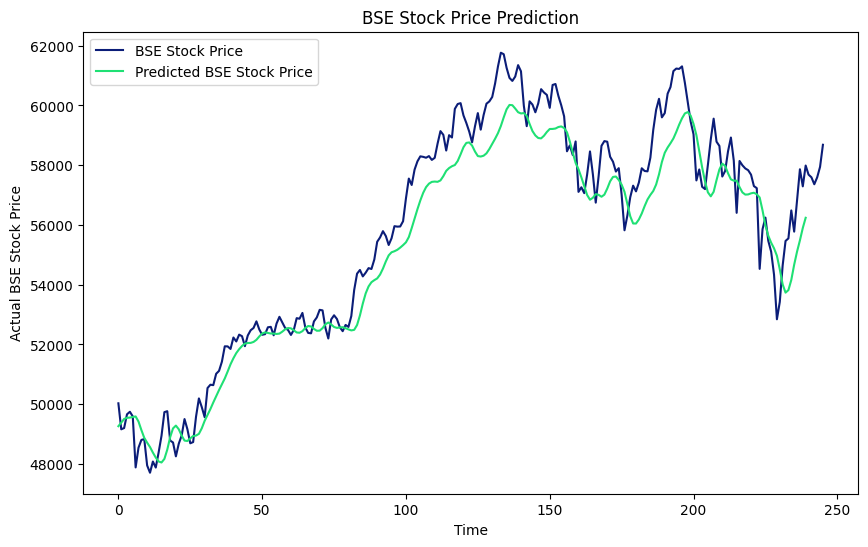

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_set, color = '#0b1d78', label = 'BSE Stock Price')
plt.plot(predicted_bse_stock_price, color = '#1fe074', label = 'Predicted BSE Stock Price')
plt.title('BSE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual BSE Stock Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import math

# Calculate mean squared error
mse = mean_squared_error(test_set[:240],predicted_bse_stock_price)

# Calculate RMSE
rmse = math.sqrt(mse)

print("RMSE:", rmse)


RMSE: 1077.8890013330304


In [ ]:
from sklearn.metrics import mean_squared_error
import math

# Calculate mean squared error
mse = mean_squared_error(google_test_g[:101],predicted_bse_stock_price_g)

# Calculate RMSE
rmse = math.sqrt(mse)

print("RMSE:", rmse)


RMSE: 5.274777566063024


In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
mse = np.mean((test_set[:240] - predicted_bse_stock_price)**2)
tss = np.mean((test_set[:240] - np.mean(predicted_bse_stock_price))**2)
r_squared = 1 - (mse / tss)

print("R-squared: ", r_squared)


R-squared:  0.9242115470474538


In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
mse = np.mean((google_test_g[:101] - predicted_bse_stock_price_g)**2)
tss = np.mean((google_test_g[:101] - np.mean(predicted_bse_stock_price_g))**2)
r_squared = 1 - (mse / tss)

print("R-squared: ", r_squared)


R-squared:  0.7418362041978757


# **GRU**

In [ ]:
from keras.layers import Dense, GRU

In [ ]:
train['Date'] = pd.to_datetime(train.Date,format='%Y-%m-%d')
train.index = train['Date']


In [ ]:
tester1['Date'] = pd.to_datetime(tester1.Date,format='%Y-%m-%d')
tester1.index = tester1['Date']

In [ ]:
result = pd.concat([train, tester1], axis=0)

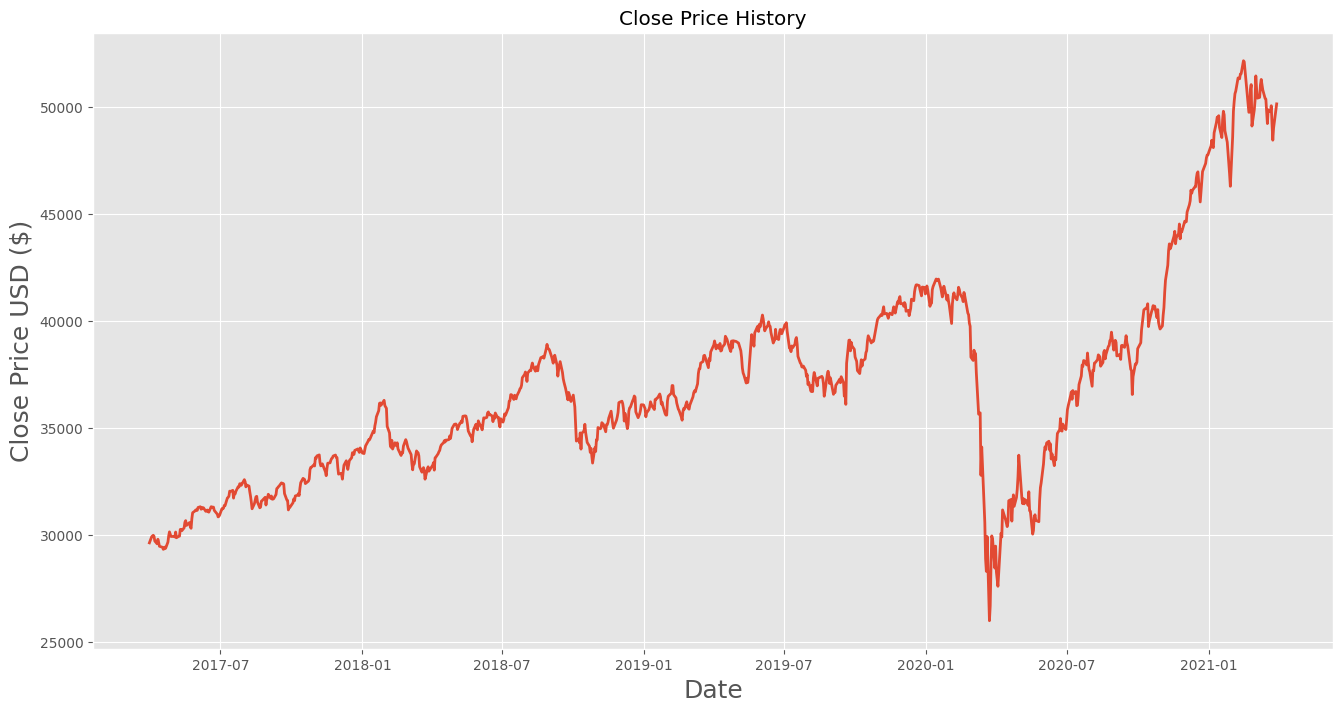

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(train['Close'],linewidth=2)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()


In [ ]:
import math
data = result.filter(['Close'])

#Converting the dataframe to a numpy array
dataset = data.values

#Get/Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
#Split the data into x_train and y_train data sets
train_data = scaled_data[0:training_data_len  , : ]
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [ ]:
from keras.layers import Dropout
gru_model = Sequential()

gru_model.add(GRU(units=50,return_sequences=True,input_shape=(x_train.shape[1], 1)))

gru_model.add(GRU(units=50,return_sequences=True))

gru_model.add(GRU(units=50,return_sequences=False))

gru_model.add(Dense(units=25))
gru_model.add(Dense(units=1))

In [ ]:
gru_model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
h = gru_model.fit(x_train, y_train, batch_size=50, epochs=100)

Epoch 1/100
19/19 [==============================] - 11s 95ms/step - loss: 0.0206
Epoch 2/100
19/19 [==============================] - 3s 152ms/step - loss: 0.0026
Epoch 3/100
19/19 [==============================] - 2s 100ms/step - loss: 7.5262e-04
Epoch 4/100
19/19 [==============================] - 2s 94ms/step - loss: 5.6109e-04
Epoch 5/100
19/19 [==============================] - 2s 93ms/step - loss: 4.4917e-04
Epoch 6/100
19/19 [==============================] - 2s 94ms/step - loss: 4.4224e-04
Epoch 7/100
19/19 [==============================] - 2s 94ms/step - loss: 4.1622e-04
Epoch 8/100
19/19 [==============================] - 2s 113ms/step - loss: 4.1711e-04
Epoch 9/100
19/19 [==============================] - 3s 140ms/step - loss: 3.8562e-04
Epoch 10/100
19/19 [==============================] - 2s 94ms/step - loss: 3.7053e-04
Epoch 11/100
19/19 [==============================] - 2s 94ms/step - loss: 3.6014e-04
Epoch 12/100
19/19 [==============================] - 2s 95ms/step

In [ ]:
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

#Convert x_test to a numpy array
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [ ]:
train_predictions = gru_model.predict(x_train)
train_predictions = scaler.inverse_transform(train_predictions)#Undo scaling

rmse_train=np.sqrt(np.mean(((train_predictions- y_train)**2)))

#Getting the models predicted price values
predictions = gru_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)#Undo scaling

#Calculate/Get the value of RMSE
rmse_test=np.sqrt(np.mean(((predictions- y_test)**2)))

8/8 [==============================] - 0s 20ms/step


In [ ]:
rmse_test

583.4202222853582

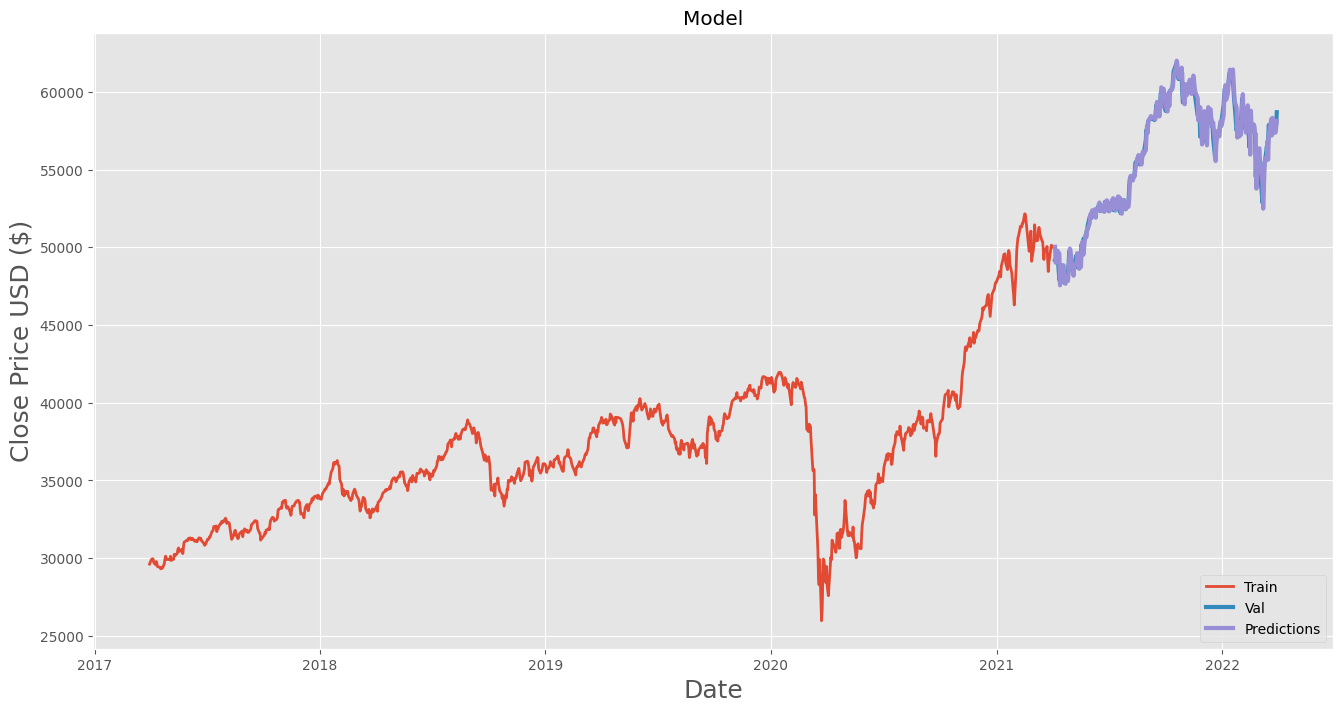

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'],linewidth=2)
plt.plot(valid[['Close', 'Predictions']],linewidth=3)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

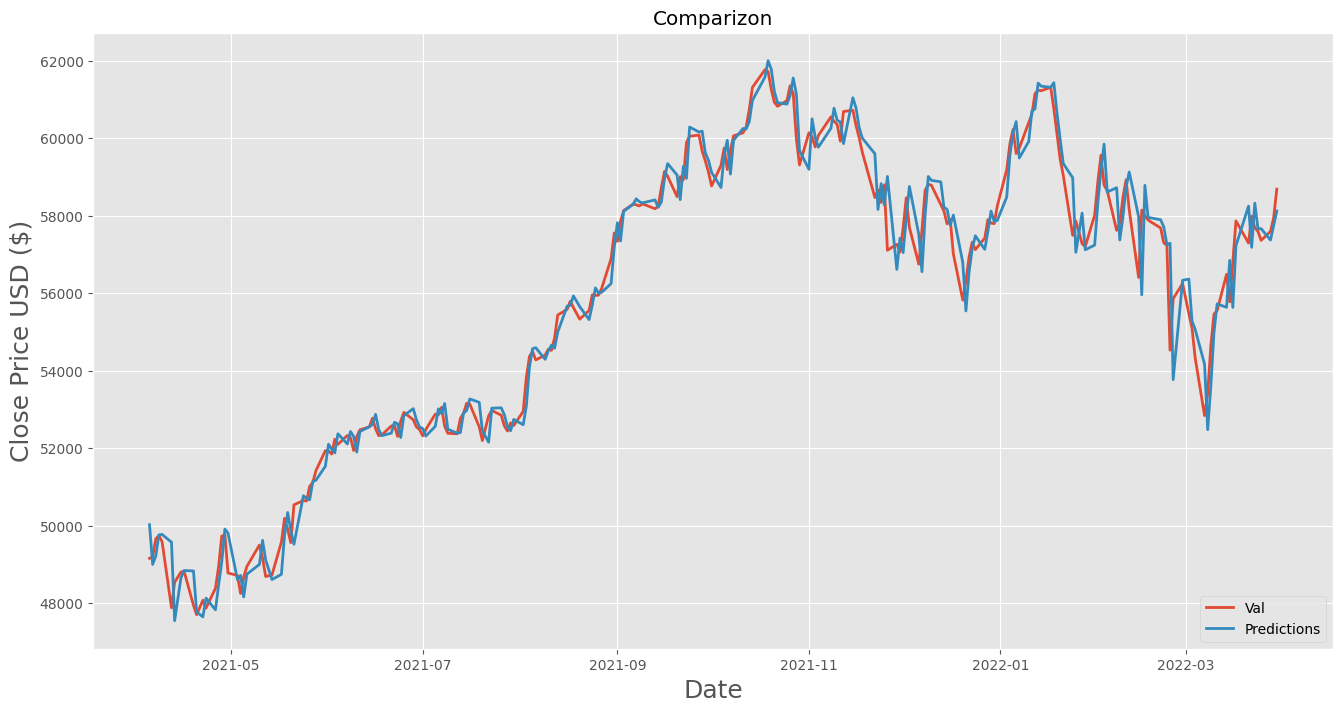

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Comparizon')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']],linewidth=2)
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()


In [ ]:
print(valid)
print('RMSE test :',rmse_test)


                   Close   Predictions
Date                                  
2021-04-05  49159.320312  50027.429688
2021-04-06  49201.390625  49002.863281
2021-04-07  49661.761719  49225.054688
2021-04-08  49746.210938  49765.652344
2021-04-09  49591.320312  49777.570312
...                  ...           ...
2022-03-24  57595.679688  57658.531250
2022-03-25  57362.199219  57665.031250
2022-03-28  57593.488281  57370.078125
2022-03-29  57943.648438  57745.785156
2022-03-30  58683.988281  58119.601562

[245 rows x 2 columns]
RMSE test : 583.4202222853582


In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
mse = np.mean((valid[:245] - predictions)**2)
tss = np.mean((valid[:245] - np.mean(predictions))**2)
r_squared = 1 - (mse / tss)

print("R-squared: ", r_squared)

R-squared:  Close          0.976642
Predictions    1.000000
dtype: float64


# **ARIMA**

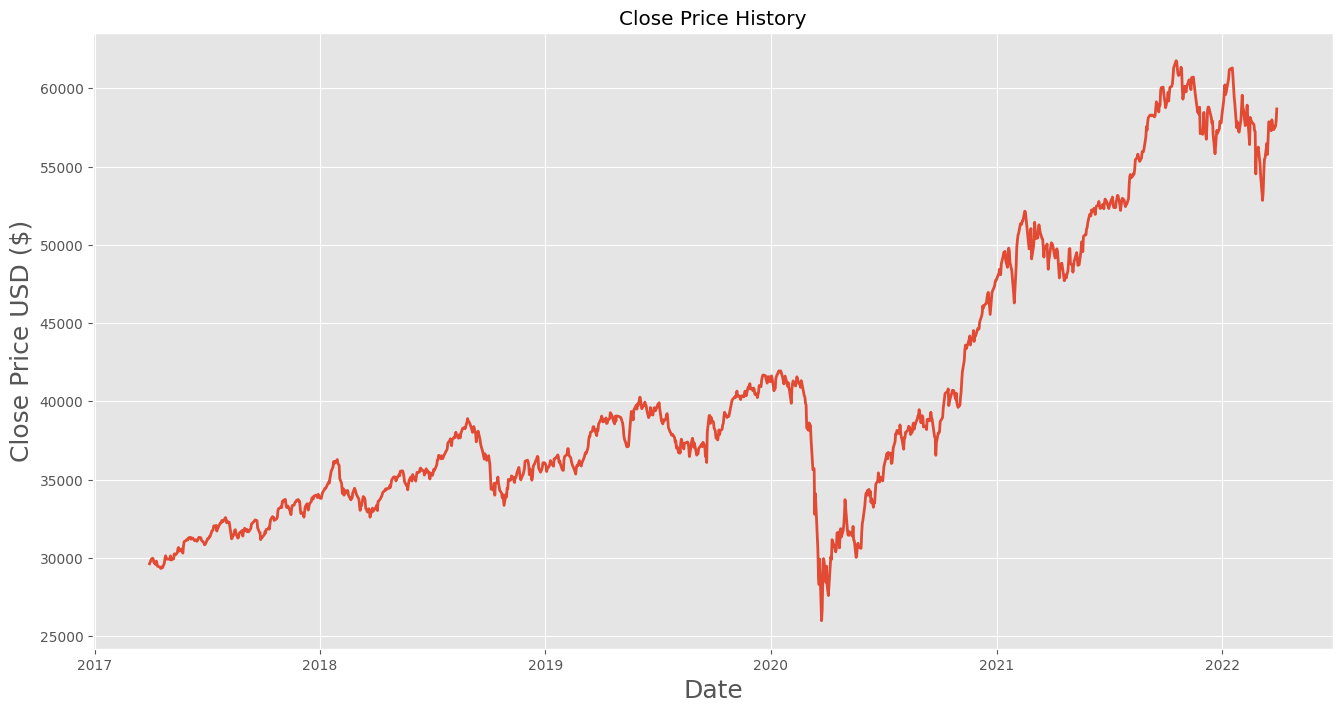

In [ ]:

plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(result['Close'],linewidth=2)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()


In [ ]:
train_data, test_data = result[0:int(len(result)*0.8)], result[int(len(result)*0.8):]
plt.figure(figsize=(16,8))


<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

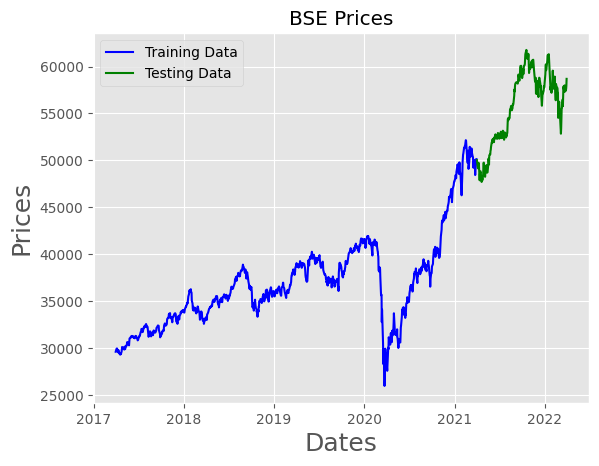

In [ ]:
plt.title('BSE Prices')
plt.xlabel('Dates',fontsize=18)
plt.ylabel('Prices',fontsize=18)
plt.plot(train_data['Close'], 'blue', label='Training Data')
plt.plot(test_data['Close'], 'green', label='Testing Data')
plt.legend()

In [ ]:
def func(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))
train_ar = train_data['Close'].values
test_ar = test_data['Close'].values

In [ ]:
!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)


<class 'list'>


In [ ]:
from math import sqrt
result = pd.DataFrame({'Actual':test_ar,'Predicted':predictions})
print(result)

#diplaying analytics
error = mean_squared_error(test_ar, predictions)
error1 = sqrt(mean_squared_error(test_ar, predictions))
print('Testing Root Mean Squared Error: %.3f' % error1)
print('Testing Mean Squared Error: %.3f' % error)
error2 = func(test_ar, predictions)
print('Mean absolute percentage error: %.3f' % error2)
print('Accuracy obtained: ',  100.000 - error2)


           Actual     Predicted
0    50029.828125  50163.361978
1    49159.320312  49951.122244
2    49201.390625  49080.958491
3    49661.761719  49270.689618
4    49746.210938  49797.601799
..            ...           ...
241  57595.679688  57843.034227
242  57362.199219  57673.333511
243  57593.488281  57329.073633
244  57943.648438  57660.723677
245  58683.988281  57915.735567

[246 rows x 2 columns]
Testing Root Mean Squared Error: 563.676
Testing Mean Squared Error: 317730.275
Mean absolute percentage error: 0.749
Accuracy obtained:  99.25133831310791


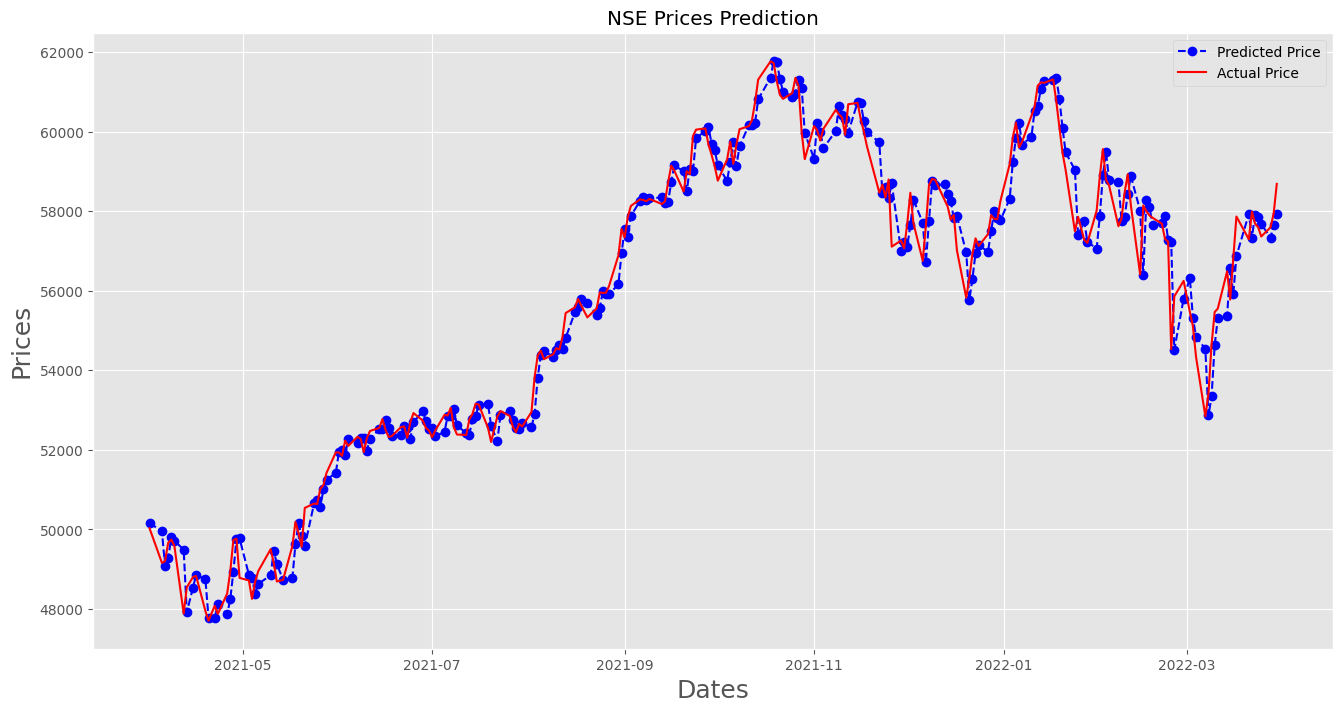

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(test_data.index, predictions, color='blue',marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.title('NSE Prices Prediction')
plt.xlabel('Dates',fontsize=18)
plt.ylabel('Prices',fontsize=18)
plt.legend()

# **Sentimental Analysis**

In [ ]:
!pip install vaderSentiment

In [ ]:
!pip install vaderSentiment
from textblob import TextBlob
import pandas as pd
import nltk
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from nltk.corpus import stopwords
from textblob import Word

Loading Texual Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/india-news-headlines.csv')
print(df.head())


   publish_date headline_category  \
0      20010101        sports.wwe   
1      20010102           unknown   
2      20010102           unknown   
3      20010102           unknown   
4      20010102           unknown   

                                       headline_text  
0  win over cena satisfying but defeating underta...  
1  Status quo will not be disturbed at Ayodhya; s...  
2                Fissures in Hurriyat over Pak visit  
3              America's unwanted heading for India?  
4                 For bigwigs; it is destination Goa  


In [ ]:
df.head(10)

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
5,20010102,unknown,Extra buses to clear tourist traffic
6,20010102,unknown,Dilute the power of transfers; says Riberio
7,20010102,unknown,Focus shifts to teaching of Hindi
8,20010102,unknown,IT will become compulsory in schools
9,20010102,unknown,Move to stop freedom fighters' pension flayed


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3297172 entries, 0 to 3297171
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 75.5+ MB


In [ ]:
df = df.drop(['headline_category'], axis=1)
df.head()

,publish_date,headline_text
0,20010101,win over cena satisfying but defeating underta...
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa


In [ ]:
df['publish_date'] = pd.to_datetime(df['publish_date'],
                                      format = '%Y%m%d')

In [ ]:
df.head()

,publish_date,headline_text
0,2001-01-01,win over cena satisfying but defeating underta...
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa


In [ ]:
df = df.rename(columns={'publish_date':'date','headline_text': 'headline'})
df.head()

,date,headline
0,2001-01-01,win over cena satisfying but defeating underta...
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa


In [ ]:
start_date = pd.to_datetime('2017-03-31')
end_date = pd.to_datetime('2021-03-31')
df = df.loc[(df['date'] >= start_date) & (df['date'] <= end_date)]

In [ ]:
df = df.reset_index()
df = df.drop('index', axis=1)
df.head()

,date,headline
0,2017-03-31,Nookalamma festival ushers in Ugadi for north ...
1,2017-03-31,Calangute still awaits sewerage system
2,2017-03-31,India Open Super Series 2017: PV Sindhu v Sain...
3,2017-03-31,Ali Asgar plays an Adivasi woman
4,2017-03-31,diya aur baati hum actor anas rashid i met her...


In [ ]:
df['headline'] = df.groupby(['date']).transform(lambda x: ' '.join(x))
df = df.drop_duplicates()
df.reset_index(inplace = True, drop = True)
df.head()

,date,headline
0,2017-03-31,Nookalamma festival ushers in Ugadi for north ...
1,2017-04-01,Are you an obsessive lover? 10 fragrance hacks...
2,2017-04-02,Two arrested with cannabis in J&K What's your ...
3,2017-04-03,Lalu Prasad demands probe into EVM malfunction...
4,2017-04-04,RBI failed to implement demonetisation properl...


Merging stock data with the textual data

In [ ]:
train_new = train.rename(columns={'Date': 'date', 'Open': 'open', 'High': 'high', 'Low': 'low',
                         'Close': 'close', 'Volume': 'volume'})

train_new.head()

,date,open,high,low,close,volume
0,2017-03-31,29633.910156,29687.640625,29552.609375,29620.500000,11800
1,2017-04-03,29737.730469,29926.939453,29705.720703,29910.220703,10100
2,2017-04-05,29996.029297,30007.480469,29817.689453,29974.240234,11200
3,2017-04-06,29946.890625,29954.250000,29817.589844,29927.339844,11300
4,2017-04-07,29850.710938,29886.119141,29668.449219,29706.609375,14700


In [ ]:
train_new.tail()

,date,open,high,low,close,volume
978,2021-03-23,49876.210938,50264.648438,49661.921875,50051.441406,13400
979,2021-03-24,49786.468750,49854.578125,49120.339844,49180.308594,9200
980,2021-03-25,49201.980469,49247.949219,48236.351562,48440.121094,14300
981,2021-03-26,48969.250000,49234.660156,48699.910156,49008.500000,10600
982,2021-03-30,49331.679688,50268.449219,49331.679688,50136.578125,10500


In [ ]:
bse_merge = pd.merge(train_new, df, how='inner', on='date')
bse_merge

,date,open,high,low,close,volume,headline
0,2017-03-31,29633.910156,29687.640625,29552.609375,29620.500000,11800,Nookalamma festival ushers in Ugadi for north ...
1,2017-04-03,29737.730469,29926.939453,29705.720703,29910.220703,10100,Lalu Prasad demands probe into EVM malfunction...
2,2017-04-05,29996.029297,30007.480469,29817.689453,29974.240234,11200,Bagaha hospital: Nothing changed in last 43 ye...
3,2017-04-06,29946.890625,29954.250000,29817.589844,29927.339844,11300,Whenever I thought I should quit; a good film ...
4,2017-04-07,29850.710938,29886.119141,29668.449219,29706.609375,14700,10 erotic books dirtier than Fifty Shades of G...
...,...,...,...,...,...,...,...
790,2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,26600,I never thought I had a voice until today: Vid...
791,2020-06-25,34525.390625,35081.609375,34499.781250,34842.101562,24600,Truck firms look for new export markets to sel...
792,2020-06-26,35144.781250,35254.878906,34910.339844,35171.269531,24800,Containment zone residents slam high prices ch...
793,2020-06-29,34926.949219,35032.359375,34662.058594,34961.519531,18300,6 hot and stylish bikini looks of Katrina Kaif...


Data Preprocessing

In [ ]:
bse_merge['headline'] = bse_merge['headline'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [ ]:
bse_merge['headline'] = bse_merge['headline'].str.replace('\d','')

In [ ]:
bse_merge['headline'] = bse_merge['headline'].str.replace('[^\w\s]','')

In [ ]:
import nltk
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
sw = stopwords.words('english')
bse_merge['headline'] = bse_merge['headline'].apply(lambda x: " ".join(
    x for x in x.split() if x not in sw))

In [ ]:
remove = pd.Series(' '.join(bse_merge['headline']).split()).value_counts()[-1000:]
bse_merge['headline'] = bse_merge['headline'].apply(lambda x: " ". join(x for x in x.split()
                                                              if x not in remove))

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
bse_merge['headline'] = bse_merge['headline'].apply(lambda x: " ".join(
    [Word(word).lemmatize() for word in x.split()]))

In [ ]:
bse_merge.head()

,date,open,high,low,close,volume,headline
0,2017-03-31,29633.910156,29687.640625,29552.609375,29620.500000,11800,nookalamma festival usher ugadi north coastal ...
1,2017-04-03,29737.730469,29926.939453,29705.720703,29910.220703,10100,lalu prasad demand probe evm malfunctioning ar...
2,2017-04-05,29996.029297,30007.480469,29817.689453,29974.240234,11200,bagaha hospital nothing changed last year firm...
3,2017-04-06,29946.890625,29954.250000,29817.589844,29927.339844,11300,whenever thought quit good film came way aishw...
4,2017-04-07,29850.710938,29886.119141,29668.449219,29706.609375,14700,erotic book dirtier fifty shade grey temple pr...


In [ ]:
bse_merge['headline'][0:15]

0     nookalamma festival usher ugadi north coastal ...
1     lalu prasad demand probe evm malfunctioning ar...
2     bagaha hospital nothing changed last year firm...
3     whenever thought quit good film came way aishw...
4     erotic book dirtier fifty shade grey temple pr...
5     sakhavu puthan panam superhero comic movie mar...
6     watch hair tan summer fertility could directly...
7     natural way lighten dark underarms rakshit she...
8     top banned book india shakespeare meet kathaka...
9     sex leave broken rib review dove lament anthol...
10    dog bite case daily pkula civil hospital raaga...
11    jeweller get year jail term disclosing swiss b...
12    mercedes benz q sale co say highest ever okhad...
13    pay park moneyspinner smc dont show anger sath...
14    reversing diabetes take hold expert call susta...
Name: headline, dtype: object

DEFINING FUNCTIONS TO GET SUBJECTIVITY AND POLARITY

In [ ]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Get polarity:

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [ ]:
bse_merge['subjectivity'] = bse_merge['headline'].apply(get_subjectivity)
bse_merge['polarity'] = bse_merge['headline'].apply(get_polarity)

In [ ]:
bse_merge.head()

,date,open,high,low,close,volume,headline,subjectivity,polarity
0,2017-03-31,29633.910156,29687.640625,29552.609375,29620.500000,11800,nookalamma festival usher ugadi north coastal ...,0.396482,0.040100
1,2017-04-03,29737.730469,29926.939453,29705.720703,29910.220703,10100,lalu prasad demand probe evm malfunctioning ar...,0.422808,0.054991
2,2017-04-05,29996.029297,30007.480469,29817.689453,29974.240234,11200,bagaha hospital nothing changed last year firm...,0.377483,0.046132
3,2017-04-06,29946.890625,29954.250000,29817.589844,29927.339844,11300,whenever thought quit good film came way aishw...,0.406224,0.033153
4,2017-04-07,29850.710938,29886.119141,29668.449219,29706.609375,14700,erotic book dirtier fifty shade grey temple pr...,0.384157,0.069506


DENSITY PLOT OF POLARITY

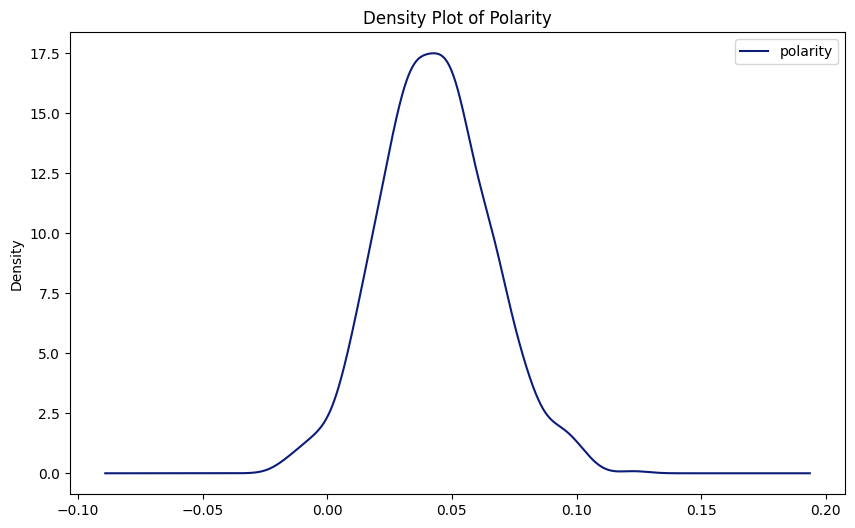

In [ ]:
pd.DataFrame(bse_merge['polarity']).plot(kind='density', figsize=(10, 6),
                             color=['#0b1d78'])

plt.title("Density Plot of Polarity")
plt.show()

qss

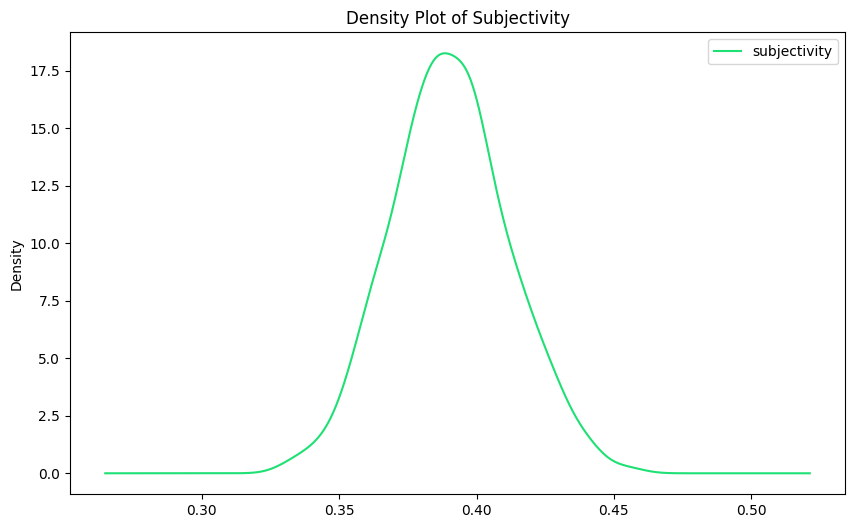

In [ ]:
pd.DataFrame(bse_merge['subjectivity']).plot(kind='density', figsize=(10, 6),
                             color=['#1fe074'])

plt.title("Density Plot of Subjectivity")
plt.show()

SENTIMENT SCORES

In [ ]:
def getSIA(text):
    sia = SentimentIntensityAnalyzer()
    sentiment= sia.polarity_scores(text)
    return sentiment

In [ ]:
compound=[]
neg=[]
pos=[]
neu=[]
SIA=0

for i in range (0, len(bse_merge['headline'])):
    SIA= getSIA(bse_merge['headline'][i])
    compound.append(SIA['compound'])
    neg.append(SIA['neg'])
    pos.append(SIA['pos'])
    neu.append(SIA['neu'])

In [ ]:
bse_merge['compound']= compound
bse_merge['neg']= neg
bse_merge['pos']=pos
bse_merge['neu']=neu

bse_merge.head()

,date,open,high,low,close,volume,headline,subjectivity,polarity,compound,neg,pos,neu
0,2017-03-31,29633.910156,29687.640625,29552.609375,29620.500000,11800,nookalamma festival usher ugadi north coastal ...,0.396482,0.040100,-0.9998,0.159,0.118,0.723
1,2017-04-03,29737.730469,29926.939453,29705.720703,29910.220703,10100,lalu prasad demand probe evm malfunctioning ar...,0.422808,0.054991,-0.9999,0.168,0.108,0.724
2,2017-04-05,29996.029297,30007.480469,29817.689453,29974.240234,11200,bagaha hospital nothing changed last year firm...,0.377483,0.046132,-0.9999,0.166,0.110,0.725
3,2017-04-06,29946.890625,29954.250000,29817.589844,29927.339844,11300,whenever thought quit good film came way aishw...,0.406224,0.033153,-0.9998,0.155,0.105,0.740
4,2017-04-07,29850.710938,29886.119141,29668.449219,29706.609375,14700,erotic book dirtier fifty shade grey temple pr...,0.384157,0.069506,-0.9999,0.177,0.105,0.718


In [ ]:
df = bse_merge[['date','close', 'subjectivity',
                'polarity', 'compound', 'neg', 'pos', 'neu']]

df.head()

,date,close,subjectivity,polarity,compound,neg,pos,neu
0,2017-03-31,29620.500000,0.396482,0.040100,-0.9998,0.159,0.118,0.723
1,2017-04-03,29910.220703,0.422808,0.054991,-0.9999,0.168,0.108,0.724
2,2017-04-05,29974.240234,0.377483,0.046132,-0.9999,0.166,0.110,0.725
3,2017-04-06,29927.339844,0.406224,0.033153,-0.9998,0.155,0.105,0.740
4,2017-04-07,29706.609375,0.384157,0.069506,-0.9999,0.177,0.105,0.718


In [ ]:
# Save to Google Drive in CSV format
df.to_csv('/content/drive/My Drive/Colab Notebooks/data4.csv', index=False)


In [ ]:
import pandas as pd

df12 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data4.csv')
print(df12.head())


         date         close  subjectivity  polarity  compound    neg    pos  \
0  2017-03-31  29620.500000      0.396482  0.040100   -0.9998  0.159  0.118   
1  2017-04-03  29910.220703      0.422808  0.054991   -0.9999  0.168  0.108   
2  2017-04-05  29974.240234      0.377483  0.046132   -0.9999  0.166  0.110   
3  2017-04-06  29927.339844      0.406224  0.033153   -0.9998  0.155  0.105   
4  2017-04-07  29706.609375      0.384157  0.069506   -0.9999  0.177  0.105   

     neu  
0  0.723  
1  0.724  
2  0.725  
3  0.740  
4  0.718  


In [ ]:
df_q = df12[['date','close','compound','subjectivity',
                'polarity', 'neg', 'pos', 'neu']]

df_q.head()

,date,close,compound,subjectivity,polarity,neg,pos,neu
0,2017-03-31,29620.500000,-0.9998,0.396482,0.040100,0.159,0.118,0.723
1,2017-04-03,29910.220703,-0.9999,0.422808,0.054991,0.168,0.108,0.724
2,2017-04-05,29974.240234,-0.9999,0.377483,0.046132,0.166,0.110,0.725
3,2017-04-06,29927.339844,-0.9998,0.406224,0.033153,0.155,0.105,0.740
4,2017-04-07,29706.609375,-0.9999,0.384157,0.069506,0.177,0.105,0.718


In [ ]:
df_q['date'] = pd.to_datetime(df_q['date'], format='%Y-%m-%d')

In [ ]:
new_train1 = df_q.loc[(df_q['date'] >= '2017-03-31')
                     & (df_q['date'] < '2019-05-29')]

new_train1

,date,close,compound,subjectivity,polarity,neg,pos,neu
0,2017-03-31,29620.500000,-0.9998,0.396482,0.040100,0.159,0.118,0.723
1,2017-04-03,29910.220703,-0.9999,0.422808,0.054991,0.168,0.108,0.724
2,2017-04-05,29974.240234,-0.9999,0.377483,0.046132,0.166,0.110,0.725
3,2017-04-06,29927.339844,-0.9998,0.406224,0.033153,0.155,0.105,0.740
4,2017-04-07,29706.609375,-0.9999,0.384157,0.069506,0.177,0.105,0.718
...,...,...,...,...,...,...,...,...
525,2019-05-22,39110.210938,-0.9999,0.354273,0.030153,0.199,0.093,0.707
526,2019-05-23,38811.390625,-0.9993,0.433942,0.029255,0.134,0.104,0.762
527,2019-05-24,39434.718750,0.9974,0.419187,0.098483,0.119,0.135,0.746
528,2019-05-27,39683.289062,-0.9998,0.390831,0.073522,0.172,0.106,0.722


In [ ]:
new_test1 = df_q.loc[(df_q['date'] >= '2019-05-29')
                     & (df_q['date'] <= '2020-06-03')]

new_test1

,date,close,compound,subjectivity,polarity,neg,pos,neu
530,2019-05-29,39502.050781,-0.9998,0.436018,0.027139,0.176,0.107,0.717
531,2019-05-30,39831.968750,-0.9998,0.405468,0.038239,0.172,0.097,0.731
532,2019-05-31,39714.199219,-0.9998,0.416828,0.015691,0.179,0.104,0.717
533,2019-06-03,40267.621094,-0.9999,0.398231,0.048384,0.180,0.091,0.729
534,2019-06-04,40083.539062,-0.9999,0.388601,0.035823,0.181,0.095,0.724
...,...,...,...,...,...,...,...,...
771,2020-05-28,32200.589844,-0.9998,0.395447,0.048315,0.164,0.092,0.743
772,2020-05-29,32424.099609,-0.9998,0.402022,0.046215,0.163,0.103,0.734
773,2020-06-01,33303.519531,-0.9998,0.365567,0.048102,0.166,0.094,0.740
774,2020-06-02,33825.531250,-0.9997,0.378164,0.066150,0.157,0.105,0.738


 CREATE HYBRID MODEL

In [ ]:
df = df12[['close', 'subjectivity',
                'polarity', 'compound', 'neg', 'pos', 'neu']]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc2 = MinMaxScaler()
df_scaled = pd.DataFrame(sc2.fit_transform(df))
df_scaled.columns = df.columns
df_scaled.index = df.index
df_scaled.head()

,close,subjectivity,polarity,compound,neg,pos,neu
0,0.227861,0.526495,0.413996,0.00010,0.421053,0.564706,0.430108
1,0.246001,0.731730,0.519334,0.00005,0.515789,0.447059,0.440860
2,0.250010,0.378379,0.456667,0.00005,0.494737,0.470588,0.451613
3,0.247073,0.602443,0.364848,0.00010,0.378947,0.411765,0.612903
4,0.233253,0.430408,0.622012,0.00005,0.610526,0.411765,0.376344


In [ ]:
X = df_scaled.drop("close", axis=1) # drop close column
y = df_scaled["close"] # only the close column

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.6 MB/s eta 0:00:00


CATBOOST REGRESSOR

In [ ]:
from catboost import CatBoostRegressor
cb = CatBoostRegressor(iterations = 200,
                      learning_rate = 0.1,
                      depth = 5)
u= cb.fit(X_train, y_train)

y_pred_cat = u.predict(X_test)

0:	learn: 0.2028773	total: 5.38ms	remaining: 1.07s
1:	learn: 0.2003039	total: 18.2ms	remaining: 1.8s
2:	learn: 0.1985435	total: 19.1ms	remaining: 1.25s
3:	learn: 0.1963078	total: 20ms	remaining: 979ms
4:	learn: 0.1948920	total: 20.9ms	remaining: 814ms
5:	learn: 0.1926223	total: 24ms	remaining: 777ms
6:	learn: 0.1911684	total: 29.4ms	remaining: 810ms
7:	learn: 0.1903184	total: 30.3ms	remaining: 728ms
8:	learn: 0.1893542	total: 31.2ms	remaining: 662ms
9:	learn: 0.1883924	total: 32ms	remaining: 609ms
10:	learn: 0.1872189	total: 32.9ms	remaining: 565ms
11:	learn: 0.1855890	total: 33.8ms	remaining: 529ms
12:	learn: 0.1840841	total: 34.7ms	remaining: 500ms
13:	learn: 0.1827606	total: 35.9ms	remaining: 477ms
14:	learn: 0.1820270	total: 43.5ms	remaining: 536ms
15:	learn: 0.1804601	total: 52.6ms	remaining: 605ms
16:	learn: 0.1794587	total: 56.3ms	remaining: 606ms
17:	learn: 0.1783726	total: 60.1ms	remaining: 608ms
18:	learn: 0.1772986	total: 62.7ms	remaining: 598ms
19:	learn: 0.1766165	total: 6

In [ ]:
y_pred_cat

array([0.77625537, 0.65711973, 0.66239878, 0.70874185, 0.4009299 ,
       0.55852297, 0.6075157 , 0.6209973 , 0.674248  , 0.58291023,
       0.4322806 , 0.73428494, 0.53951292, 0.61234164, 0.49522273,
       0.39012364, 0.62063222, 0.60733406, 0.44246032, 0.74081127,
       0.39875285, 0.76524789, 0.63148277, 0.72962492, 0.81152536,
       0.53378353, 0.64553453, 0.51867685, 0.47372837, 0.73574391,
       0.66433182, 0.54995019, 0.64112879, 0.74885278, 0.48677222,
       0.59773651, 0.81484838, 0.52122478, 0.62914433, 0.58104476,
       0.53386959, 0.69968728, 0.58553469, 0.6940277 , 0.65078201,
       0.56123076, 0.59143972, 0.56072102, 0.69101693, 0.63161173,
       0.53337114, 0.69610935, 0.51010277, 0.68351478, 0.47238186,
       0.57355999, 0.48927877, 0.36312415, 0.53695524, 0.5986078 ,
       0.73636611, 0.52416235, 0.40260388, 0.67695073, 0.57960715,
       0.55715475, 0.46622432, 0.69601878, 0.48914516, 0.52089193,
       0.64200801, 0.59861   , 0.54039686, 0.46281192, 0.30447

In [ ]:
import numpy as np
mse_cb = ((y_test - y_pred_cat) ** 2).mean()
rmse_cb = np.sqrt(mse_cb)

print("RMSE for CatBoost Model: ",rmse_cb)

RMSE for CatBoost Model:  0.18513453705293287


In [ ]:
y_mean = np.mean(y_test)

# Calculate the total sum of squares (TSS)
tss = np.sum((y_test - y_mean) ** 2)

# Calculate the residual sum of squares (RSS)
rss = np.sum((y_test - y_pred_cat) ** 2)

# Calculate R-squared (R2)
r2 = 1 - (rss / tss)

print("R-squared (R2) for CatBoost Model: ", r2)

R-squared (R2) for CatBoost Model:  0.19999989445626798
